# Predicting customer churn

Using a dataset from Kaggle, which in turn comes from IBM, I attempt to train and tune an XGBoost model to act as a binary classifier to predict customer churn from various related data.

### Loading data, brief assesment, and random undersampling

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from xgboost import XGBClassifier

In [58]:
data = pd.read_csv('Customer_data.csv')
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [59]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [60]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [61]:
for col in data:
    print(data[col].value_counts())

5527-ACHSO    1
0329-GTIAJ    1
4088-YLDSU    1
4770-QAZXN    1
1816-FLZDK    1
             ..
5858-EAFCZ    1
4640-UHDOS    1
4083-BFNYK    1
6923-JHPMP    1
2616-FLVQC    1
Name: customerID, Length: 7043, dtype: int64
Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64
Yes    6361
No      682
Name: PhoneService, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
No                     3088
Yes

Beautiful null-free data, brings a tear to the eye.

In [62]:
data = data.loc[data['TotalCharges']!=" "]
data['TotalCharges'] = data['TotalCharges'].astype(float)

<ipython-input-62-cf22576dc6b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalCharges'] = data['TotalCharges'].astype(float)


<AxesSubplot:xlabel='count', ylabel='Churn'>

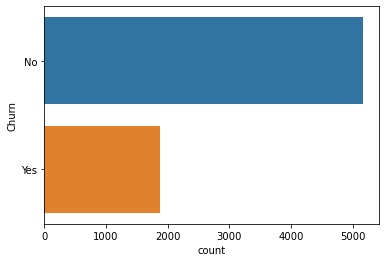

In [63]:
sn.countplot(data=data, y=data['Churn'])

Data is imbalanced enough to require some balancing, but a good nominal amount of existing churn for training purposes, therefore random undersampling of the 'No's should be sufficient. We can test if SMOTE or some other oversampling makes a difference as well, later.

In [64]:
# Could use imblearn, but let's do make our own random undersampler (and we'll make it work on not only binary measures)

def random_under(dataset=data, classes='Churn', weight = 1.0):
    
    undersampled_full_set = dataset.copy()
    counts = dataset[classes].value_counts(ascending=True)
    sample_size = counts[0]
    
    # For every category that isn't the minimum one...
    for cat in counts.index[1:]:
        rows_to_drop = len(dataset[dataset[classes]==cat]) - sample_size
        
        # ... randomly drop the number of rows there are bar the sample size
        idxs = np.random.choice(dataset[dataset[classes]==cat].index, size=rows_to_drop, replace=False)
        undersampled_full_set = undersampled_full_set.drop(idxs)
    
    return undersampled_full_set
    

In [65]:
bal_df = random_under()

<AxesSubplot:xlabel='Churn', ylabel='count'>

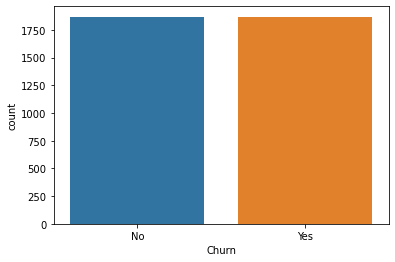

In [66]:
sn.countplot(data = bal_df, x='Churn')

And there we have it, the function adequately identifies the number of rows to drop in the majority class and randomly drops them.  
Next, encoding the categorical variables so it's suitable for xgboost.

In [67]:
for col in bal_df:
    if bal_df[col].dtype == 'object':
        bal_df[col] = bal_df[col].astype('category')
        name = col+"_code"
        bal_df[name] = bal_df[col].cat.codes
        bal_df.drop(columns=col, axis=1, inplace=True)
    else:
        pass
bal_df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,customerID_code,gender_code,Partner_code,Dependents_code,PhoneService_code,MultipleLines_code,...,OnlineSecurity_code,OnlineBackup_code,DeviceProtection_code,TechSupport_code,StreamingTV_code,StreamingMovies_code,Contract_code,PaperlessBilling_code,PaymentMethod_code,Churn_code
0,0,1,29.85,29.85,2858,0,1,0,0,1,...,0,2,0,0,0,0,0,1,2,0
2,0,2,53.85,108.15,1363,1,0,0,1,0,...,2,2,0,0,0,0,0,1,3,1
4,0,2,70.70,151.65,3466,0,0,0,1,0,...,0,0,0,0,0,0,0,1,2,1
5,0,8,99.65,820.50,3487,0,0,0,1,2,...,0,0,2,0,2,2,0,1,2,1
8,0,28,104.80,3046.05,2981,0,1,0,1,2,...,0,0,2,2,2,2,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,1,1,75.75,75.75,2606,1,0,0,1,2,...,0,0,0,0,0,0,0,1,2,1
7034,0,67,102.95,6886.25,253,0,0,0,1,2,...,2,2,2,0,2,0,0,1,1,1
7035,0,19,78.70,1495.10,3190,1,0,0,1,0,...,0,0,0,0,2,0,0,1,0,0
7040,0,11,29.60,346.45,1797,0,1,1,0,1,...,2,0,0,0,0,0,0,1,2,0


### XGBoost Classification with KFold Cross-Validation and some Hyperparameter Tuning

In [69]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [85]:
kfold = KFold(10, random_state=1, shuffle=True)

X = np.array(bal_df.iloc[:, :-1])
y = np.array(bal_df['Churn_code'])

accs = []
depths = []
etas = []

# Some parameter tuning to optimise the learning rate and max depth of the trees used
for depth in range(1, 10):
    for eta in np.arange(0.001, 0.2, 0.001): 
        model =  XGBClassifier(booster='gbtree', eta=eta, max_depth=depth)
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold, n_jobs=-1)
        accs.append(scores.mean())
        etas.append(eta)
        depths.append(depth)


Optimal value for learning rate is 0.0260, and optimal max depth is 5, giving an accuracy of 77.18%


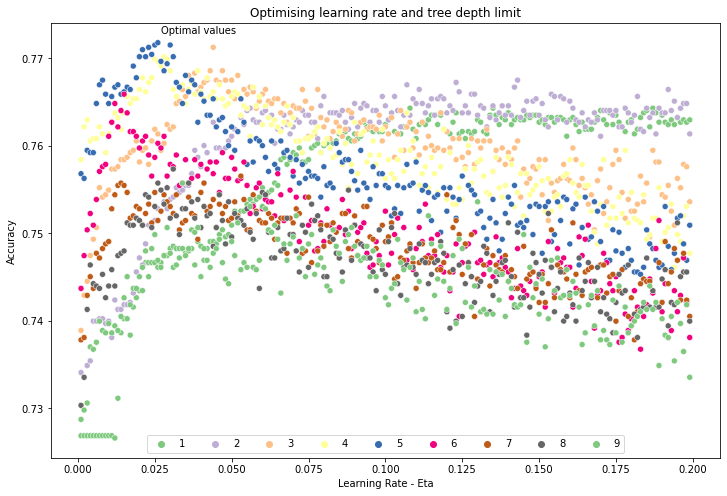

In [135]:
fig, ax = plt.subplots(figsize=(12,8))

sn.scatterplot(x=etas, y=accs, hue=depths, legend='full', palette='Accent')
plt.xlabel('Learning Rate - Eta')
plt.ylabel('Accuracy')
plt.title('Optimising learning rate and tree depth limit')
ax.legend(loc='lower center', ncol=9)

optimal_eta = etas[accs.index(max(accs))]
optimal_depth = depths[accs.index(max(accs))]

plt.annotate('Optimal values', (optimal_eta+0.001, max(accs)+0.001 ))

print("Optimal value for learning rate is {:.4f}, and optimal max depth is {}, giving an accuracy of {:.2f}%".format(optimal_eta, optimal_depth, max(accs)*100))